**Introduction**

Welcome to our final notebook where we are attempting to find the best neighborhood in Pittsburgh. We collected three separate sets of data around the general ideas of safety and health.

In our project, we looked at 3 different datasets for 3 different submetrics:

- Arrest Rate (40%)
- Obesity Rate (40%)
- Air Quality (20%)

All of these relate to health and safety. We believe that this is extremely important when considering which neighborhood was best because one's well-being takes charge over any other complaints that could be made about an area.

Another way of thinking that we had explored was thinking of things as a person in real estate. More specifically, we thought about exploring property value in certain areas, with the idea that the higher the value, the more desirable and overall "better" the neighborhood would be.

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

obesity_df = pd.read_csv("obesity-ac-2006-2010censustracts.csv")
# Removed all non-Pittburgh data
obesity_df = obesity_df[obesity_df["City Neighborhood"].notna()]
#Got rid of unneccessary columns
cols = [i for i in list(obesity_df.columns) if i not in ["City Neighborhood", "2006-2010 estimate of obesity"]]
obesity_df = obesity_df.drop(columns = cols, axis = 1)

# created dictionary to organize data to specific neighborhoods to find average obesity rate
neighborhood_dict = {}

#adds individual neighborhoods to list
for index,row in obesity_df.iterrows():
    if row["City Neighborhood"] in neighborhood_dict:
        neighborhoodlist = neighborhood_dict[row["City Neighborhood"]]
        neighborhoodlist[0] += 1
        neighborhoodlist[1] += float(row["2006-2010 estimate of obesity"])
    else:
        neighborhood_dict[row["City Neighborhood"]] = [1, float(row["2006-2010 estimate of obesity"])]

# loops through list to find average rate for each        
for neighborhood in neighborhood_dict:
    avg = (neighborhood_dict[neighborhood][1] / neighborhood_dict[neighborhood][0])
    neighborhood_dict[neighborhood] = avg
    
# created a new dataframe that changes the label and sorts by obesity rate    
neighborhood_obesity_df = pd.DataFrame(list(neighborhood_dict.items()), columns = ["neighborhood", "obesity_rate"])
obesity_sorted = neighborhood_obesity_df.sort_values("obesity_rate", ascending = True)

In [55]:
#reading csv w/ pandas .read_csv
air_df = pd.read_csv("air_quality.csv")#imports
#creating columns and assigning values 
cols = [i for i in list(air_df.columns) if i not in ["site", "index_value"]]
air_df = air_df.drop(columns = cols, axis = 1)
air_df
#create dictionary for air quality index value
air_dict = {}
#loops through data set (daily measurements), keeps count of each county's avg PPM2.5 over each day
for index, row in air_df.iterrows():
    if row["site"] in air_dict:
        air_dict[row["site"]] = [air_dict[row["site"]][0] + 1, (air_dict[row["site"]][1] + float(row["index_value"]))]
    else:
        air_dict[row["site"]] = [1, float(row["index_value"])]
        
for item in air_dict.keys():
    val = (air_dict[item][1]/air_dict[item][0])
    air_dict[item] = val

neighborhood_air_df = pd.DataFrame(list(air_dict.items()), columns = ['neighborhood', 'index_value'])
neighborhood_air_df.sort_values("index_value", ascending = False, inplace = True)

In [56]:
import pandas as pd
import matplotlib.pyplot as plt #import statements
police = pd.read_csv("police.csv") #read arrest data
arrests_by_city = police.groupby('INCIDENTNEIGHBORHOOD')['PK'].count() #groupby neightboorhood/accidently put city
arrests_df = pd.DataFrame({'neighborhood': arrests_by_city.index, 'count': arrests_by_city.values}) #new data frame of just count and neighborhood
arrests_df = arrests_df.drop(labels=[63,64,65], axis=0) #removing out of city, out of country, and out of state
arrests_df.loc[54, "count"] += arrests_df.loc[56, "count"] #Combining to agree with population csv
arrests_df.loc[54, "count"] += arrests_df.loc[57, "count"]
arrests_df.loc[90, "count"] += arrests_df.loc[91, "count"]
arrests_df.loc[18, "count"] += arrests_df.loc[19, "count"]
arrests_df.loc[54, "neighborhood"] = "Mount Oliver + Mt. Oliver Neighborhood:" #Renaming to agree with population csv
arrests_df.loc[90, "neighborhood"] = "Troy Hill + Troy Hill-Herrs Island:"
arrests_df.loc[18, "neighborhood"] = "Central Northside + Central North Side:"
arrests_df = arrests_df.drop(labels=[56,57,91,19], axis=0) #Dropping the extra
population_df = pd.read_csv("populations.csv") #read pop data
population_df.rename(columns={"City": "neighborhood"}, inplace=True) #Renaming to agree with arrests
population_df.rename(columns={"Population": "population"}, inplace=True) #Vanity things
merged_df = arrests_df.merge(population_df, on="neighborhood") #Merge the sets
merged_df["average arrests per year"] = merged_df["count"] / 7 #Calculating metric
merged_df["arrest rate"] = (merged_df["average arrests per year"] / merged_df["population"]) * 100
only_rates = merged_df[["neighborhood", "arrest rate"]] #df of only the rate and neighborhood
only_rates = only_rates.sort_values(by="arrest rate") #top ten for plot

In [57]:
main_df = pd.DataFrame(columns = ['neighborhood', 'arrest rate', 'index_value', 'obesity_rate'])
main_df = pd.merge(neighborhood_air_df, only_rates, on = 'neighborhood', how = 'outer')
main_df = pd.merge(main_df, obesity_sorted, on = 'neighborhood', how = 'outer')
main_df.sort_values('neighborhood', inplace = True)
main_df

,neighborhood,index_value,arrest rate,obesity_rate
102,Allegheny Center,NaN,18.067677,0.313581
76,Allegheny West,NaN,3.772418,0.206399
85,Allentown,NaN,5.051429,0.353925
56,Arlington,NaN,2.117251,0.334520
93,Arlington Heights,NaN,8.138173,0.473120
...,...,...,...,...
13,West Mifflin,6.335548,NaN,NaN
47,West Oakland,NaN,1.558043,NaN
111,West oakland,NaN,NaN,0.366391
31,Westwood,NaN,0.973814,0.268106


In [64]:
final_metric_list = []
for index, row in main_df.iterrows():
    temp = 0
    if(not math.isnan(row["index_value"] * 0.2)):
        temp += (row["index_value"] * 0.2)
    if(not math.isnan(row["arrest rate"] * 0.4)):
        temp += (row["arrest rate"] * 0.4)
    if(not math.isnan(row["obesity_rate"] * 0.4)):
        temp += (row["obesity_rate"] * 0.4)
    if(math.isnan(row["obesity_rate"])):
        temp = np.nan
    final_metric_list.append(temp)
    
main_df['Weighted Health Metric'] = final_metric_list
main_df.sort_values('Weighted Health Metric', inplace = True, ascending = True)
main_df.head(30)

,neighborhood,index_value,arrest rate,obesity_rate,Weighted Health Metric
106,North oakland,NaN,NaN,0.155867,0.062347
107,Southside Flats,NaN,NaN,0.247180,0.098872
108,Southside Slopes,NaN,NaN,0.289930,0.115972
109,Troy Hill/Herr's Island,NaN,NaN,0.311834,0.124734
110,Spring Hill-Cityview,NaN,NaN,0.335105,0.134042
111,West oakland,NaN,NaN,0.366391,0.146556
112,Mount Oliver Neighborhood,NaN,NaN,0.380567,0.152227
113,Central Northside,NaN,NaN,0.442131,0.176852
16,Squirrel Hill North,NaN,0.338190,0.125941,0.185653
114,Crawford Roberts,NaN,NaN,0.488691,0.195476


<Axes: title={'center': 'Top 30 Neighborhoods'}, xlabel='neighborhood'>

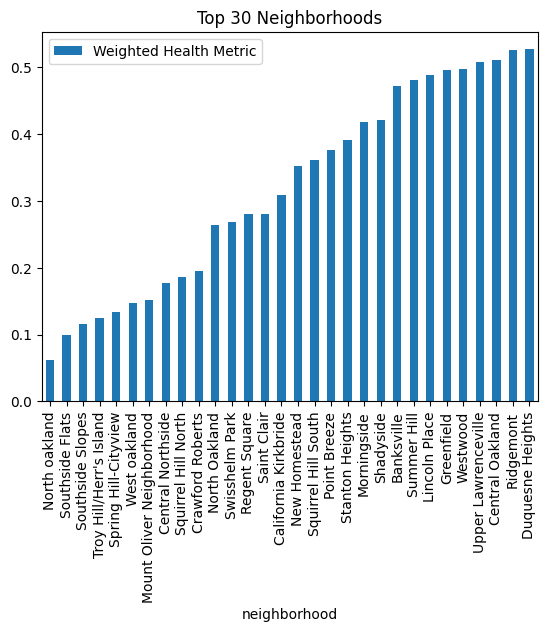

In [67]:
temp_df = main_df.head(30)
temp_df.plot.bar(x = 'neighborhood', y = 'Weighted Health Metric', title = 'Top 30 Neighborhoods')

The data we collected each were measured by a certain submetric. Combining these submetrics gives us the result of our combined metric (Weighted Health Metric), the neighborhood that is the best based 
on its safety. 

The metrics: 
-Obesity Rates
-Air Quality (based on PPM2.5 measurements)
-Arrest Rates

For our the air quality metric, we look at results from the Air Quality index supplied by Alleghany County's Health Department. The results are taken from air quality monitors that measure each of the respective areas particualte matter. The concentration of the particulate matter correlates to the amount of risk resulting from breathing the air. This fact relates directly to the overall metric, safety. The neighborhood with the best air quality would have the best rating within the submetric and in turn in the overall metric. 

When looking at the obesity metric, with results taken from the Alleghany County's Health Department as well, would also directly relate to the safety metric. Areas with higher obesity would indicate a lack of good general health. This would be resulting from a possible lack of sufficient nutritional options. The neighborhood with the lowest obesity rates would be considered the best neighborhood based on our safety metric.

For the arrest rates metric, with results from the City of Pittsburgh, we can see how "safe" an area is based on the amount of crime, or arrests there are in the area. Areas with high crime rates indicate that the area is generally unsafe or is riddled with crime. Areas with low crime rates are generally safer and more desirable to live in. The neighborhood with the lowest crime rate would be considered the best neighborhood based on our safety metric.

**Conclusion**

In conclusion, we found that North Oakland was the "best" neighborhood in Pittsburgh by comparing obesity rates, arrest rates, and air quality. These 3 submetrics help us see the overall aspect of health and safety in the Pittsburgh area and narrow down which neighborhoods are the best overall.

**Individual Conclusions**

**Owen**:
    My personal favorite neighborhood is the one that I grew up in. Like North Oakland, it is somewhat near the city but it is more in the suburbs. I grew up in Essex County, Massachusetts which is outside of Boston, like North Oakland is to Pittsburgh. I find many similarities between the data we discovered about North Oakland and the area that I grew up in. The air quality is relatively good, people have access to amble and healthy food, leading to healthy lifestyles, and arrest rates are low, meaning that the area is safe. I think that I would enjoy living in North Oakland, as it appears to be somewhat similar to the area that I call home, even if it is a 10 hour drive away.